# Slow fast projections


In this section, the mean/harmonic extraction from moving average procedures and the resulting signal are investigated, with the emphasis put on contamination effects and non-stationary.
The goal is to understand what kind of signal one obtains -- compared to one's expectations -- when applying a general transform to a function (signal, noise) $f$:
\begin{align}
f_K(t) &= \frac{1}{T} \int_{t-T/2}^{t+T/2} K(t') f(t') dt', \\
\end{align}
where $K$ is an appropriate kernel for the computation at hand.
For a moving average, $K(t)=1$, while for an harmonic analysis, $K(t)=e^{-i\omega_0 t}$.

The signal of interest in the present context generally consist of the combination of a turbulent process and a non-stationary tidal field. 
For simplicity, we assume in the following that they are not correlated.
In that case, the signal is a linear superposition of each process, and can be treated separately.
For the turbulent background part, one can prescribe the statistical properties of the process. 
For the internal tide, the synthetic signal is a combination of a quasi-monochromatic support with prescribed statistics or analytical form of the perturbation around.

\AP{proposition from here on}
The turbulent signal is assumed to be stationary with a null expected value and an exponential autocorrelation:
\begin{align}
\mathbb{E} [ u_t ] &= 0, \\
R_t(\tau) &= \mathbb{E} [ u_t(t+\tau) u_t(t) ] = \bar{u}_t^2 e^{-|\tau|/T_t},
\end{align}
The power spectrum of this signal is then given by:
\begin{align}
P_t(\omega) &= \int_{-\infty}^{\infty} R_t[\tau] e^{-i\omega\tau} d\tau, \\
&= \frac{2T_t}{1+(\omega T_t)^2} \times \bar{u}_t^2
\end{align}

The quasi-periodical signal is assumed to be composed of both a stationary and non-stationary component:
\begin{align}
u_p(t) = \mathcal{R}\{ (\bar u_p 
+  u_p' (t) ) e^{i\omega_0 t} \},
\end{align}
where $\bar u_p$ is a complex constant and $u_p'$ is a slowly evolving complex function characterized by:
\begin{align}
\mathbb{E} [ u_p'(t) ] &= 0, \\
R_p'(\tau) &= \mathbb{E} [ u_p'(t+\tau) u_p'^\ast(t) ], \\
\mathbb{E} [ u_p'(t+\tau) u_p'(t) ] &= 0, \\
\end{align}
This leads to:
\begin{align}
\mathbb{E} [ u_p(t) ] &= \mathcal{R}\{ \bar u_p e^{i\omega_0 t} \}, \\
R_p(\tau) &= \mathbb{E} [ u_p(t+\tau) u_p^\ast(t) ], \\
&= \mathcal{R}\{ R_p'(\tau)/2 \times e^{i\omega_0 \tau} \},
\end{align}
(check last equation with experiment)
Is $R_p'$ real? 
We'll assume it is but will have to be verified:
\begin{align}
R_p(\tau) &= \mathbb{E} [ u_p(t+\tau) u_p^\ast(t) ], \\
&= R_p'(\tau)/2 \cos {\omega_0 \tau},
\end{align}
Finally, let's assume:
\begin{align}
R_p'(\tau) &= \alpha \bar u^2_p e^{-|\tau|/T_p},
\end{align}
where $\alpha$ represents the non-stationary to stationary variance ratio.
This leads to:
\begin{align}
R_p(\tau) &= 
\frac{\alpha \bar u^2_p}{2} 
e^{-|\tau|/T_p} \cos {\omega_0 \tau},
\end{align}


Expentially decorrelated time series are generated with an order 1 ARMA process.

- arma statsmodel [doc](https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.arma_generate_sample.html#statsmodels.tsa.arima_process.arma_generate_sample)
- arma on [wikipedia](https://en.wikipedia.org/wiki/Autoregressive–moving-average_model)

In [1]:
import itertools 
import numpy as np
import xarray as xr
import statsmodels.api as sm

%matplotlib inline
import matplotlib.pyplot as plt

import sstats.tseries as ts
import sstats as ss

In [2]:
from dask.distributed import Client, LocalCluster
#
cluster = LocalCluster()
#
#from dask_jobqueue import PBSCluster
#cluster = PBSCluster()
#w = cluster.scale(28*1)
#
client = Client(cluster)
client

Client Scheduler: tcp://127.0.0.1:61762 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 17.18 GB


---

## generate synthetic data

In [3]:
# utils
exp = lambda name, Td: (ts
                .exp_autocorr((100, 1./24.), 
                            Td, 
                            1, 
                            draws=2000,
                            name=name)
                .rename({'tau':'Td'})
                   )

# theoretical expectations
It = lambda T, omega: (2*(omega**2*T + omega**2 + T 
                           + (-omega**2*np.cos(omega*T) - 2*omega*np.sin(omega*T) 
                              + np.cos(omega*T))*np.exp(-T) - 1
                           )/(T**2*(omega**4 + 2*omega**2 + 1))
                        )
Ip = lambda T, omega, omega0: (It(T, omega-omega0)+It(T, omega+omega0))/2.

In [4]:
# decorrelation time scales
T = np.arange(1,30,1) 

# slow:
ds = exp('x_s', T).to_dataset()

# fast:
omega = 2.*np.pi*2.
x = exp('x', T)
y = exp('y', T)
ds['x_p'] = np.real(x*np.cos(omega*ds['time']) 
                    + 1j*y*np.sin(omega*ds['time'])
                   )

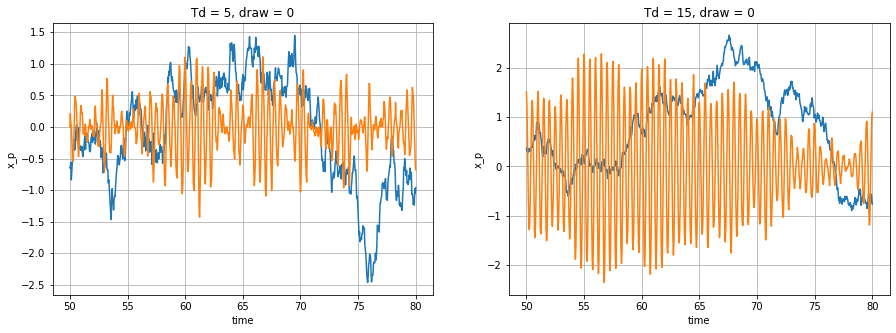

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
for Td, ax in zip([5,15], axs):
    _ds = ds.sel(draw=0, Td=Td, time=slice(50,80))
    _ds['x_s'].plot(ax=ax)
    _ds['x_p'].plot(ax=ax)
    ax.grid()

In [6]:
# check variances of signals
print('mean slow variance = {:.2f}'.format(ds['x_s'].std().values))
print('mean periodic variance = {:.2f}'.format(ds['x_p'].std().values))

mean slow variance = 0.96
mean periodic variance = 0.68


### project on mean and harmonic parts

In [7]:
proj = lambda da, omega, tslice: (da*np.exp(-1j*omega*da.time)).sel(time=tslice).mean('time')

T = [2, 10, 20]

D = {}
for _T in T:
    tslice = slice(50, 50+_T)
    _p = xr.merge([proj(ds[v], 0., tslice).rename(v+'_mean') for v in ['x_s', 'x_p']]
                  +[proj(ds[v], omega, tslice).rename(v+'_omega') for v in ['x_s', 'x_p']]
                 )
    
    _D = np.sqrt((np.abs(_p)**2).mean('draw'))
    _Td = _D.Td
    _D['x_s_mean_th'] = np.sqrt(It(_T/_Td, 0.))
    _D['x_s_omega_th'] = np.sqrt(It(_T/_Td, omega*_Td))
    _D['x_p_mean_th'] = np.sqrt(Ip(_T/_Td, 0., omega*_Td)/2.) # tmp rescaling
    _D['x_p_omega_th'] = np.sqrt(Ip(_T/_Td, omega*_Td, omega*_Td)/2.) # tmp rescaling
    D[_T] = _D.persist()

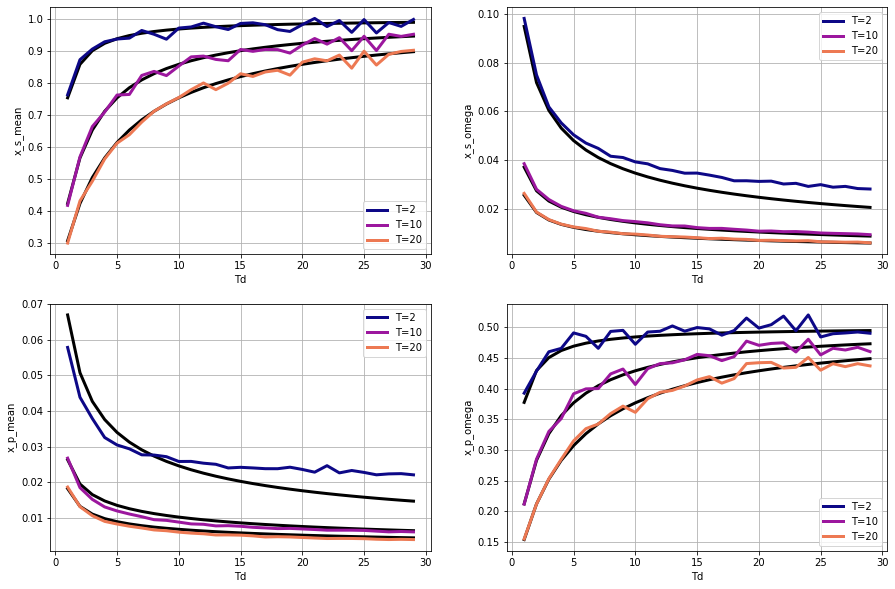

In [8]:
colors = ss.get_cmap_colors(len(D))

fig, axs = plt.subplots(2,2, figsize=(15,10))
for v, ax in zip(itertools.product(['x_s', 'x_p'],['_mean','_omega']), axs.flatten()):
    _v = ''.join(v)
    for _T, c in zip(D, colors):
        D[_T][_v+'_th'].plot(ax=ax, color='k', lw=3)
        D[_T][_v].plot(ax=ax, color=c, lw=3, label='T={}'.format(_T))
        ax.grid()
    ax.legend()